In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Reshape,LeakyReLU,Dropout,Conv2DTranspose, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, )
from tensorflow.keras.optimizers import Adam

# Data

## Download Data

In [2]:
!pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d jessicali9530/celeba-dataset
!unzip "/content/celeba-dataset.zip" -d "/content/dataset/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197604.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197605.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197606.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197607.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197608.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197609.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197610.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197611.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197612.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197613.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197614.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197615.jpg  
  inflating: /content/dat

## Prepare Data

In [3]:
BATCH_SIZE = 128
IM_SHAPE = (64,64,3)
LEARNING_RATE = 2e-4
LATENT_DIM=100
EPOCHS=20

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/dataset/img_align_celeba/img_align_celeba", label_mode=None, image_size=(IM_SHAPE[0], IM_SHAPE[1]), batch_size=BATCH_SIZE
)

Found 202599 files.


In [5]:
dataset

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

In [6]:
def preprocess(image):
  return tf.cast(image, tf.float32) / 127.5 - 1.0

In [7]:
train_dataset = (
    dataset
    .map(preprocess)
    .unbatch()
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .batch(BATCH_SIZE,drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

In [8]:
for d in train_dataset.take(1):
  print(d.shape)

(128, 64, 64, 3)


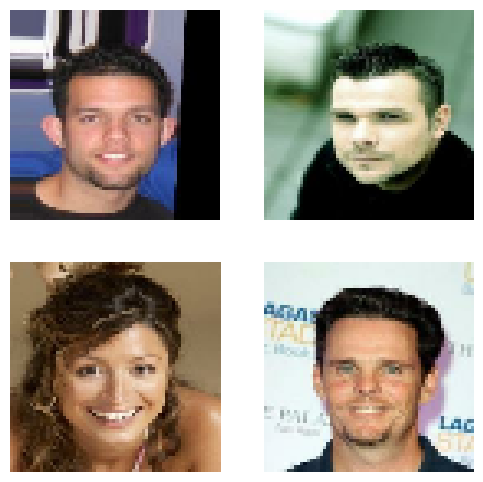

In [9]:
plt.figure(figsize = (6,6))
k=0
n = 4
for i in range(n):
  ax = plt.subplot(2,2, k+1)
  plt.imshow((d[i]+1)/2)
  plt.axis("off")
  k+=1

# MOdeling

In [10]:
generator=tf.keras.Sequential([
  Input(shape=(LATENT_DIM,)),
  Dense(4*4*LATENT_DIM),
  Reshape((4,4,LATENT_DIM)),

  Conv2DTranspose(512,kernel_size=4,strides=2, padding='same'),
  BatchNormalization(),
  LeakyReLU(0.2),

  Conv2DTranspose(256,kernel_size=4,strides=2, padding='same'),
  BatchNormalization(),
  LeakyReLU(0.2),

  Conv2DTranspose(128,kernel_size=4,strides=2, padding='same'),
  BatchNormalization(),
  LeakyReLU(0.2),

  Conv2DTranspose(3,kernel_size=4,strides=2, activation=tf.keras.activations.tanh, padding='same'),

],name='generator')

In [11]:
generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 1600)                │         161,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 4, 4, 100)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 8, 8, 512)           │         819,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 8, 8, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 16, 16, 256)         │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 32, 32, 128)         │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 64, 64, 3)           │           6,147 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,612,867 (13.78 MB)

 Trainable params: 3,611,075 (13.78 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [12]:
discriminator=tf.keras.Sequential([
  Input(shape=(IM_SHAPE[0],IM_SHAPE[1],3)),

  Conv2D(64,kernel_size=4,strides=2, padding='same'),
  LeakyReLU(0.2),

  Conv2D(128,kernel_size=4,strides=2, padding='same'),
  BatchNormalization(),
  LeakyReLU(0.2),

  Conv2D(256,kernel_size=4,strides=2, padding='same'),
  BatchNormalization(),
  LeakyReLU(0.2),

  Conv2D(1,kernel_size=4,strides=2, padding='same'),

  Flatten(),
  Dense(1,activation='sigmoid')


],name='discriminator')

In [13]:
discriminator.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 64)          │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 4, 4, 1)             │           4,097 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 664,530 (2.53 MB)

 Trainable params: 663,762 (2.53 MB)

 Non-trainable params: 768 (3.00 KB)

In [14]:
class ShowImage(tf.keras.callbacks.Callback):
    def __init__(self, latent_dim=100):
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        n=6
        k=0
        out=self.model.generator(tf.random.normal(shape=(36, self.latent_dim)))
        plt.figure(figsize=(16,16))
        for i in range(n):
          for j in range(n):
            ax=plt.subplot(n,n,k+1)
            plt.imshow((out[k]+1)/2,)
            plt.axis('off')
            k+=1
        plt.savefig("generated/gen_images_epoch_{}.png".format(epoch+1))

In [15]:
class GAN(tf.keras.Model):
  def __init__(self,discriminator,generator):
    super(GAN,self).__init__()
    self.discriminator=discriminator
    self.generator=generator

  def compile(self,d_optimizer,g_optimizer,loss_fn):
    super(GAN,self).compile()
    self.d_optimizer=d_optimizer
    self.g_optimizer=g_optimizer
    self.loss_fn=loss_fn
    self.d_loss_metric=tf.keras.metrics.Mean(name='d_loss')
    self.g_loss_metric=tf.keras.metrics.Mean(name='g_loss')

  @property
  def metrics(self):
    return [self.d_loss_metric,self.g_loss_metric]

  def train_step(self,real_images):
    batch_size=tf.shape(real_images)[0]

    ######## Discriminator
    random_noise=tf.random.normal(shape=(batch_size,LATENT_DIM))
    fake_images=self.generator(random_noise)

    real_labels=tf.ones((batch_size,1))+0.25*tf.random.uniform((batch_size,1),minval=-1,maxval=1)
    fake_labels=tf.zeros((batch_size,1))+0.25*tf.random.uniform((batch_size,1),)

    with tf.GradientTape() as recorder:
      real_predictions=self.discriminator(real_images)
      d_loss_real=self.loss_fn(real_labels,real_predictions)

      fake_predictions=self.discriminator(fake_images)
      d_loss_fake=self.loss_fn(fake_labels,fake_predictions)

      d_loss=d_loss_real+d_loss_fake

    partial_derivatives = recorder.gradient(d_loss,self.discriminator.trainable_weights)
    self.d_optimizer.apply_gradients(zip(partial_derivatives, self.discriminator.trainable_weights))

    ############# Generator
    random_noise=tf.random.normal(shape=(batch_size,LATENT_DIM))
    flipped_fake_labels=tf.ones((batch_size,1))

    with tf.GradientTape() as recorder:

      fake_predictions=self.discriminator(self.generator(random_noise))
      g_loss=self.loss_fn(flipped_fake_labels,fake_predictions)

    partial_derivatives = recorder.gradient(g_loss,self.generator.trainable_weights)
    self.g_optimizer.apply_gradients(zip(partial_derivatives, self.generator.trainable_weights))

    self.d_loss_metric.update_state(d_loss)
    self.g_loss_metric.update_state(g_loss)

    return {'d_loss':self.d_loss_metric.result(),
            'g_loss':self.g_loss_metric.result()}

In [16]:
gan=GAN(discriminator,generator)
gan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE,beta_1=0.5),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE,beta_1=0.5),
    loss_fn=tf.keras.losses.BinaryCrossentropy(),
)

In [17]:
!mkdir generated

mkdir: cannot create directory ‘generated’: File exists


In [ ]:
EPOCHS=10
history=gan.fit(train_dataset,epochs=EPOCHS,callbacks=[ShowImage(LATENT_DIM)])

Epoch 1/10
   1582/Unknown 280s 166ms/step - d_loss: 1.0197 - g_loss: 1.2201

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1582/1582 ━━━━━━━━━━━━━━━━━━━━ 282s 167ms/step - d_loss: 1.0198 - g_loss: 1.2200
Epoch 2/10
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 317s 172ms/step - d_loss: 1.2016 - g_loss: 0.9055
Epoch 3/10
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 276s 174ms/step - d_loss: 1.1830 - g_loss: 0.9299
Epoch 4/10
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 319s 173ms/step - d_loss: 1.2189 - g_loss: 0.8567
Epoch 5/10
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 276s 174ms/step - d_loss: 1.2256 - g_loss: 0.8426
Epoch 6/10
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 277s 175ms/step - d_loss: 1.2327 - g_loss: 0.8381
Epoch 7/10
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 319s 173ms/step - d_loss: 1.2116 - g_loss: 0.8435
Epoch 8/10
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 322s 173ms/step - d_loss: 1.2064 - g_loss: 0.8573
Epoch 9/10
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 276s 174ms/step - d_loss: 1.2070 - g_loss: 0.8560
Epoch 10/10
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 323s 175ms/step - d_loss: 1.1915 - g_loss: 0.8364


In [ ]:
plt.plot(history.history['d_loss'])
plt.plot(history.history['g_loss'])
plt.title('GAN Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['d_loss', 'g_loss'], loc='upper left')
plt.show()

# Testing And Evaluation

# Testing Generator


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate random noise
random_noise = np.random.normal(0, 1, (36, LATENT_DIM))

# Generate images
generated_images = gan.generator(random_noise)

# Plot the images
plt.figure(figsize=(10, 10))
for i in range(36):
    plt.subplot(6, 6, i + 1)
    plt.imshow((generated_images[i].numpy() + 1) / 2)  # Normalize images
    plt.axis('off')
plt.show()


# Testing Discriminator


In [ ]:
# Test with real and fake images
real_images = next(iter(train_dataset))  # Sample batch from training dataset
fake_images = gan.generator(tf.random.normal((real_images.shape[0], LATENT_DIM)))

# Get predictions from discriminator
real_preds = gan.discriminator(real_images)
fake_preds = gan.discriminator(fake_images)

# Print the output
print(f"Real image predictions: {real_preds.numpy()}")
print(f"Fake image predictions: {fake_preds.numpy()}")
